### **Pipline**


* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

In [1]:
import numpy as np 
import pandas as pd 
import random as rd 
import datetime 
from sklearn.preprocessing import LabelEncoder
from itertools import product

import matplotlib.pyplot as plt 
import seaborn as sns 

In [30]:
sales=pd.read_csv("sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
sub=pd.read_csv("sample.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

In [31]:
print("----------Top-5- Record----------")
print(sales.head(5))
print("-----------Information-----------")
print(sales.info())
print("-----------Data Types-----------")
print(sales.dtypes)
print("----------Missing value-----------")
print(sales.isnull().sum())
print("----------Null value-----------")
print(sales.isna().sum())
print("----------Shape of Data----------")
print(sales.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        flo

**In our case from 134.4+ MB, we went to 61.6+ MB**

In [32]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sales_2 = downcast_dtypes(sales)
print(sales_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


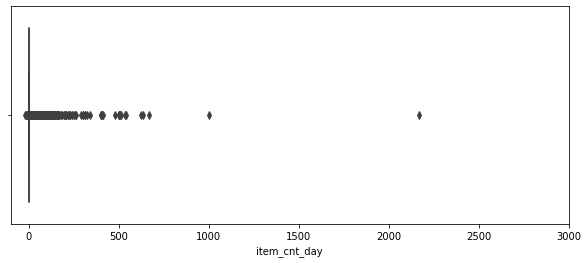

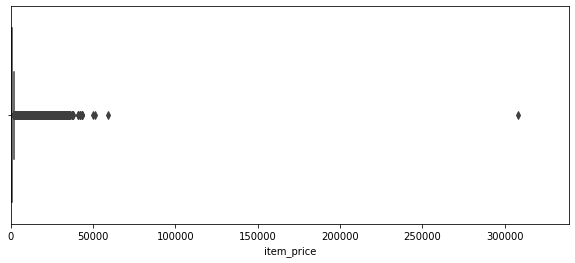

In [33]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_2.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_2.item_price.min(), sales_2.item_price.max()*1.1)
sns.boxplot(x=sales_2.item_price)

### heal data and remove outliers

In [34]:
sales_2 = sales_2[sales_2.item_price<100000]
sales_2 = sales_2[sales_2.item_cnt_day<1001]

In [35]:
print("item_price < 0" , sales_2[sales_2.item_price<0])
print(100*"=")
median = sales_2[(sales_2.shop_id==32)&(sales_2.item_id==2973)&(sales_2.date_block_num==4)&(sales_2.item_price>0)].item_price.median()
sales_2.loc[sales_2.item_price<0, 'item_price'] = median

item_price < 0               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


### work with shops/items/cats objects and features

 **Several shops are duplicates of each other (according to its name). Fix train and test set.**

In [36]:
sales_2.loc[sales_2.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

sales_2.loc[sales_2.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

sales_2.loc[sales_2.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [37]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])

item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat= item_cat[['item_category_id','type_code', 'subtype_code']]

item.drop(['item_name'], axis=1, inplace=True)

### Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [38]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales_3 = sales_2[sales_2.date_block_num==i]
    matrix.append(np.array(list(product([i], sales_3.shop_id.unique(), sales_3.item_id.unique())), dtype='int16'))

In [39]:
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [40]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [41]:
sales_2['revenue'] = sales_2['item_price'] *  sales_2['item_cnt_day']

In [42]:
sales_2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.000000,1.0,999.000000
1,03.01.2013,0,25,2552,899.000000,1.0,899.000000
2,05.01.2013,0,25,2552,899.000000,-1.0,-899.000000
3,06.01.2013,0,25,2554,1709.050049,1.0,1709.050049
4,15.01.2013,0,25,2555,1099.000000,1.0,1099.000000


In [43]:
group = sales_2.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [44]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


Aggregate train set by shop/item pairs to calculate target aggreagates, then clip(0,20) target value. 

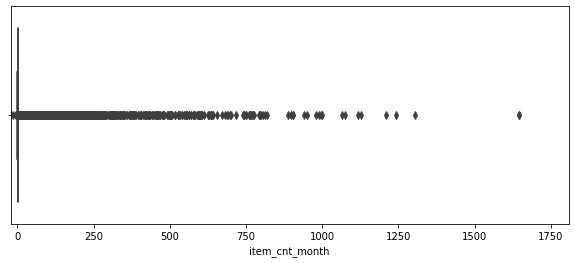

In [45]:
plt.figure(figsize=(10,4))
plt.xlim(group.item_cnt_month.min(), group.item_cnt_month.max()*1.1)
sns.boxplot(x=group.item_cnt_month)


In [46]:
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

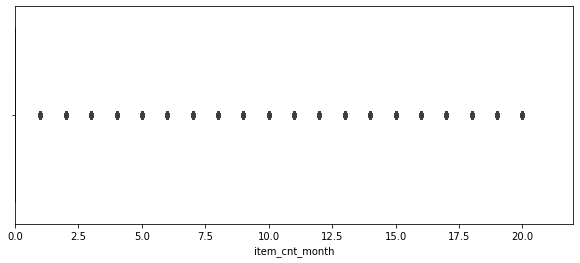

In [47]:
plt.figure(figsize=(10,4))
plt.xlim(matrix.item_cnt_month.min(), matrix.item_cnt_month.max()*1.1)
sns.boxplot(x=matrix.item_cnt_month)

### Test set

To use time tricks append test pairs to the matrix.

In [48]:
test['date_block_num'] = 34  # future month
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [49]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [50]:
# concat test and train
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) 

In [51]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,2,19,0.0,0.0
1,0,2,27,1.0,0.0
2,0,2,28,0.0,0.0
3,0,2,29,0.0,0.0
4,0,2,32,0.0,0.0


In [52]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [53]:
item.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [54]:
item_cat.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


### Shops/Items/Cats features

In [55]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, item, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_cat, on=['item_category_id'], how='left')

In [56]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [57]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0,40,11,4
1,0,2,27,1.0,0.0,0,19,5,10
2,0,2,28,0.0,0.0,0,30,8,55
3,0,2,29,0.0,0.0,0,23,5,16
4,0,2,32,0.0,0.0,0,40,11,4


**Traget lags**

In [58]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [59]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [60]:
matrix["item_cnt_month_lag_1"].unique()

array([nan,  1.,  0.,  2.,  3.,  4.,  6.,  5., 17.,  8.,  9., 10.,  7.,
       11., 12., 18., 14., 20., 15., 13., 19., 16.])

### Mean encoded features

Create date_avg_item_cnt lags

In [61]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [62]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN


Create date_item_avg_item_cnt lags

In [63]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

create date_shop_avg_item_cnt lags

In [64]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

create date_cat_avg_item_cnt lags

In [65]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

create date_shop_cat_avg_item_cnt lags

In [66]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

create date_shop_type_avg_item_cnt lags

In [67]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

create date_shop_subtype_avg_item_cnt lags

In [68]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

create date_city_avg_item_cnt lags

In [69]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

create date_item_city_avg_item_cnt lags

In [70]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

create date_type_avg_item_cnt lags

In [71]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

create date_subtype_avg_item_cnt lags

In [72]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [73]:
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Trend features
#### Price trend for the last six months.

In [76]:
group = sales_2.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = sales_2.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

### Last month shop revenue trend

In [77]:
group = sales_2.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

### Special features

In [78]:
matrix['month'] = matrix['date_block_num'] % 12

In [79]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]) #Number of days in a month. There are no leap years
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

In [80]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num   

In [81]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num      

Months since the first sale for each shop/item pair and for item only.

In [82]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

### Final preparations

In [74]:
matrix = matrix[matrix.date_block_num > 11]
# Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [75]:
#Producing lags brings a lot of nulls.

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [57]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0.0,0,19,5,10,0.0,...,1.03418,1.075195,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,2,30,0.0,0.0,0,40,11,4,0.0,...,0.27002,0.291504,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,2,31,0.0,0.0,0,37,11,1,0.0,...,0.27002,0.234009,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,2,32,1.0,0.0,0,40,11,4,0.0,...,0.27002,0.291504,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,2,33,1.0,0.0,0,37,11,1,1.0,...,0.27002,0.234009,-0.225464,1.211914,0,31,1,1,12,12


In [56]:
matrix.to_pickle('data.pkl')

del matrix
del cache
del group
del items
del shops
del cats
del train

## Xgboost

In [3]:
data = pd.read_pickle('data.pkl')

In [4]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0.0,0,19,5,10,0.0,...,1.03418,1.075195,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,2,30,0.0,0.0,0,40,11,4,0.0,...,0.27002,0.291504,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,2,31,0.0,0.0,0,37,11,1,0.0,...,0.27002,0.234009,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,2,32,1.0,0.0,0,40,11,4,0.0,...,0.27002,0.291504,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,2,33,1.0,0.0,0,37,11,1,1.0,...,0.27002,0.234009,-0.225464,1.211914,0,31,1,1,12,12


In [5]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [6]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [8]:
del data


NameError: name 'data' is not defined

In [10]:
from xgboost import XGBRegressor
from xgboost import plot_importance


model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:19:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:16] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12413	validation_1-rmse:1.11704
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08616	validation_1-rmse:1.08412
[2]	validation_0-rmse:1.05295	validation_1-rmse:1.05309
[3]	validation_0-rmse:1.01018	validation_1-rmse:1.02723
[4]	validation_0-rmse:0.984142	validation_1-rmse:1.00866
[5]	validation_0-rmse:0.962195	validation_1-rmse:0.990075
[6]	validation_0-rmse:0.944697	validation_1-rmse:0.975021
[7]	validation_0-rmse:0.922515	validation_1-rmse:0.96105
[8]	validation_0-rmse:0.90889	validation_1-rmse:0.951286
[9]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [13]:
import pickle

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)
test=pd.read_csv("test.csv")
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

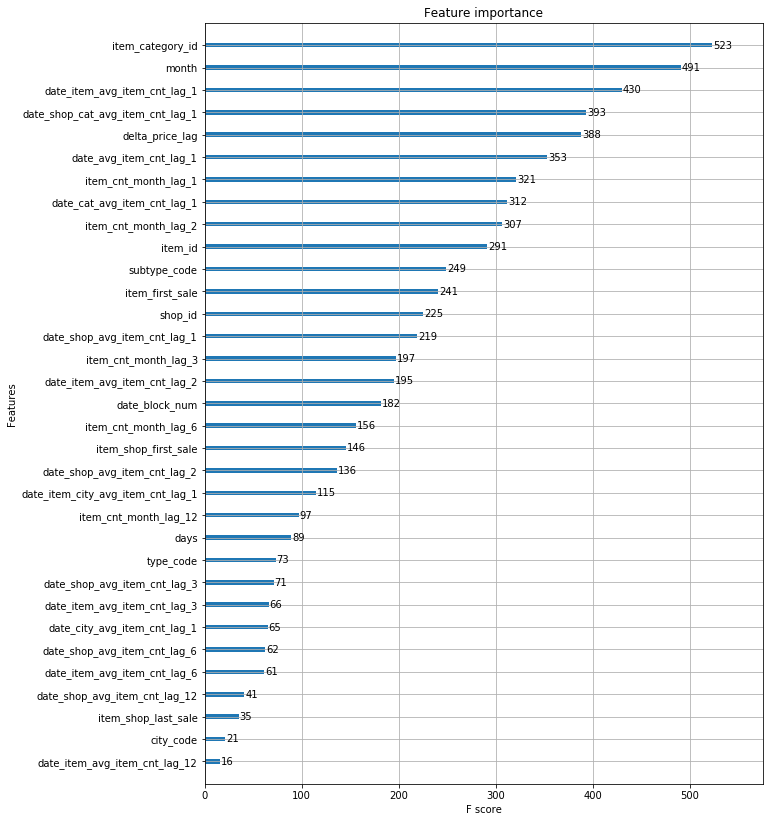

In [14]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


plot_features(model, (10,14))